<a href="https://colab.research.google.com/github/YaoGroup/DIFFICE_jax/blob/main/examples/colab/train_pinns_iso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isotropic viscosity inversion of ice shelves via PINNs

Fast running the code requires **GPU hardware** to accelerate.

To choose GPU hardware, click the "Edit" in the toolbar above and select "Notebook settings".

In the pop-up window, under the "Hardware accelerator", select "T4 GPU"

To ensure the code to run correctly in the colab, install the specific version of JAX below.

(Note that only using the GPU version of JAX, combined with the selection of GPU hardware as mentioned above, can eventually accelerate the training.)

Copying required python functions from the [DIFFICE_jax](https://github.com/YaoGroup/DIFFICE_jax) GitHub repository

In [ ]:
# install the DIFFICE_jax
!pip install DIFFICE_jax

# download the data from GitHub respository
!wget https://github.com/YaoGroup/DIFFICE_jax/raw/main/examples/real_data/data_pinns_Amery.mat


Importing the required JAX library and function file from GitHub repository

In [ ]:
import jax.numpy as jnp
import numpy as np
from jax import random
from jax.tree_util import tree_map
from scipy.io import loadmat
import time

from diffice_jax import normdata_pinn, dsample_pinn
from diffice_jax import vectgrad, ssa_iso, dbc_iso
from diffice_jax import init_pinn, solu_pinn
from diffice_jax import loss_iso_pinn
from diffice_jax import predict_pinn
from diffice_jax import adam_opt, lbfgs_opt


# Setting hyperparameters

hyper-parameters used for the training. Users are free to modify their value and check their influence on the training results


In [ ]:
# select a random seed
seed = 2134
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4)

# select the size of neural network
n_hl = 6
n_unit = 30
# set the weight for 1. equation loss and 2. boundary condition loss
lw = [0.05, 0.1]

# number of sampling points
n_smp = 5000    # for velocity data
nh_smp = 4500   # for thickness data
n_col = 5000    # for collocation points
n_cbd = 400     # for boundary condition (calving front)
# group all the number of points
n_pt = jnp.array([n_smp, nh_smp, n_col, n_cbd], dtype='int32')
# double the points for L-BFGS training
n_pt2 = n_pt * 2


# Data Loading
load and normalize tne observed data before the PINN training

In [ ]:
# load the synthetic data
rawdata = loadmat('data_pinns_Amery.mat')

# normalize the remote-sensing data for the PINN training
data_all = normdata_pinn(rawdata)
# extract the scale information for each variable
scale = data_all[4][0:2]


# Initialization

initialize the neural network and loss function

In [ ]:
# initialize the weights and biases of the network
trained_params = init_pinn(keys[0], n_hl, n_unit)

# create the solution function
pred_u = solu_pinn()

# create the data sampling function for Adam training
dataf = dsample_pinn(data_all, n_pt)
keys_adam = random.split(keys[1], 5)
# generate the data
data = dataf(keys_adam[0])

# create the data sampling function for L-BFGS training
dataf_l = dsample_pinn(data_all, n_pt2)
key_lbfgs = random.split(keys[2], 5)

# group the gov. eqn and bdry cond.
eqn_all = (ssa_iso, dbc_iso)
# create the loss function
NN_loss = loss_iso_pinn(pred_u, eqn_all, scale, lw)
# calculate the initial loss and set it as the reference value for loss
NN_loss.lref = NN_loss(trained_params, data)[0]


# Network training

Since the real ice shelf data has more complicated profile than the synthetic data. 10000 iterations of Adam, followed by another 10000 iterations of L-BFGS can only infer a **very rough** profile of the ice viscosity.

To train a high-accurate model, the number of iterations required for both Adam and L-BFGS optimization is more than 100k.


In [ ]:
# set the learning rate for Adam
lr = 1e-3
# set the training iteration
epoch1 = 10000

# training with Adam
trained_params, loss1 = adam_opt(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr=lr)


Extra training using L-BFGS to reach higher accuracy

Recommended number of iterations: 10000

In [ ]:
# set the training iteration
epoch2 = 10000
# re-sample the data and collocation points
data_l = dataf_l(key_lbfgs[1])

# training with L-bfgs
trained_params2, loss2 = lbfgs_opt(NN_loss, trained_params, data_l, epoch2)


# Prediction

Compute the solution variables and equation residue at high-resolution grids

In [ ]:
# Function of solution and equation residues based on trained networks
f_u = lambda x: pred_u(trained_params2, x)
f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:6]

# group all the function
func_all = (f_u, f_gu, ssa_iso)

# calculate the solution and equation residue at given grids for visualization
results = predict_pinn(func_all, data_all)


# Plotting the results:

Compare the synthetic data for either velocity or thickness with the corresponding network approximation

Text(0.5, 1.0, 'Network approx. $u(x,y)$ (m/s)')

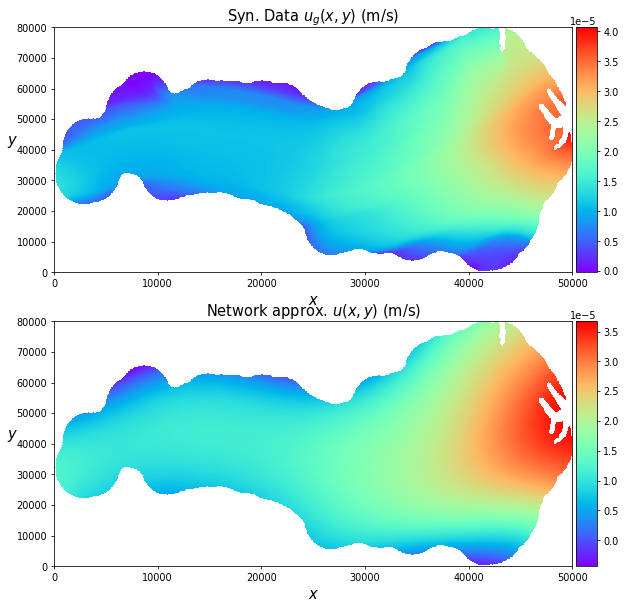

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

u_g = results['u_g']
u = results['u']

fig = plt.figure(figsize = [10, 10], dpi = 70)

ax = plt.subplot(2,1,1)
h = ax.imshow(u_g, interpolation='nearest', cmap='rainbow',
              extent=[0., 50000., 0,  80000.],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$x$', fontsize = 15)
ax.set_ylabel('$y\ $', fontsize = 15, rotation = 0)
ax.set_title('Syn. Data $u_g(x,y)$ (m/s)', fontsize = 15)


ax2 = plt.subplot(2,1,2)
h2 = ax2.imshow(u, interpolation='nearest', cmap='rainbow',
              extent=[0., 50000., 0,  80000.],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h2, cax=cax)

ax2.set_xlabel('$x$', fontsize = 15)
ax2.set_ylabel('$y\ $', fontsize = 15, rotation = 0)
ax2.set_title('Network approx. $u(x,y)$ (m/s)', fontsize = 15)


Showing the inferred viscosity via PINNs for the ice shelf

In [ ]:
# load the PINN inference of viscosity
mu = results['mu']

fig = plt.figure(figsize = [10, 5], dpi = 70)

ax = plt.subplot(1,1,1)
h = ax.imshow(mu, interpolation='nearest', cmap='rainbow',
              extent=[0., 50000., 0,  80000.],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$x$', fontsize = 15)
ax.set_ylabel('$y\ $', fontsize = 15, rotation = 0)
ax.set_title('Inferred viscosity $\mu(x,y)$', fontsize = 15)

